In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocessor as p

In [2]:
# load the dataset
train_df = pd.read_csv(".\\tweepfake_dataset\\full_train.csv")
val_df = pd.read_csv(".\\tweepfake_dataset\\full_validation.csv")
test_df = pd.read_csv(".\\tweepfake_dataset\\full_test.csv")

<h2>Data Exploration</h2>

In this section we look at the structure of the dataset after the extraction of the tweets using the twitter API

In [3]:
train_df.head()

,user_id,status_id,screen_name,text,account.type,class_type,screen_name_anonymized
0,1110407881030017024,1208265880146046976,imranyebot,YEA now that note GOOD,bot,others,bot#9
1,3171109449,1091463908118941696,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human,human#17
2,1110686081341632512,1199055191028293633,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,bot#23
3,1110307772783124480,1214698264701722626,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,bot#1
4,979586167405363200,1209229478934695937,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,bot#11


In [4]:
nRows,nCols = train_df.shape
print(f"There are {nRows} rows and {nCols} columns")

There are 20712 rows and 7 columns


<AxesSubplot:>

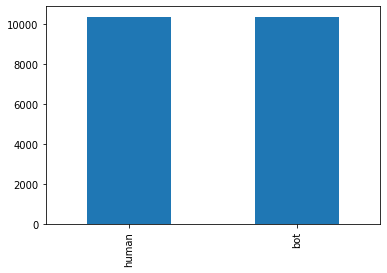

In [5]:
# from this we can see that the dataset is balanced
train_df['account.type'].value_counts().plot(kind='bar')

In [6]:
# basic stats about the dataset
train_df.describe()

,user_id,status_id,screen_name,text,account.type,class_type,screen_name_anonymized
count,20712,20712,20712,20712,20712,20712,20712
unique,41,20710,40,20712,2,4,40
top,979586167405363200,1279906540791779334,kevinhooke,YEA now that note GOOD,human,human,human#10
freq,1951,2,1951,1,10358,10358,1951


<h2>Data Pre-Processing</h2>

<p>The first task is to remove extra columns. Since we will only be using the 'text' and 'account.type' columns, we will copy them to a new dataframe.</p>

In [7]:
train_df.drop(['user_id','status_id','screen_name','class_type','screen_name_anonymized'], axis=1, inplace=True)

In [8]:
train_df.head()

,text,account.type
0,YEA now that note GOOD,bot
1,Listen to This Charming Man by The Smiths htt...,human
2,wish i can i would be seeing other hoes on the...,bot
3,The decade in the significantly easier schedul...,bot
4,"""Theim class=\""alignnone size-full wp-image-60...",bot


We now deal with hashtags, URLS, Mentions, Emojis.

In [9]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

def tokenizeTweets(tweets):
    twt = TweetTokenizer(strip_handles=True, reduce_len=True)
    # combine stop words and punctuation
    stop = stopwords.words("english") + list(string.punctuation)
    
    # create the stemmer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # filter out stop words and punctuation and send to lower case
    tokenized_tweets = []
    for tweet in tweets:
        tokens = [ lemmatizer.lemmatize(stemmer.stem(token))
              for token in twt.tokenize(tweet)
              if token.lower() not in stop]
        allText = " ".join(tokens)
        allText = re.sub(r'http\S+', '__url__', allText)
        tokens = allText.split()
        tokenized_tweets.append(tokens)
    return tokenized_tweets

train_df['cleaned_text'] = tokenizeTweets(train_df['text'])
train_df.head()

,text,account.type,cleaned_text
0,YEA now that note GOOD,bot,"[yea, note, good]"
1,Listen to This Charming Man by The Smiths htt...,human,"[listen, charm, man, smith, __url__]"
2,wish i can i would be seeing other hoes on the...,bot,"[wish, would, see, hoe, worst, part]"
3,The decade in the significantly easier schedul...,bot,"[decad, significantli, easier, schedul, like, ..."
4,"""Theim class=\""alignnone size-full wp-image-60...",bot,"[theim, class, =\, alignnon, size-ful, wp-imag..."


In [10]:
# drop the unnecessary columns and tokenize the tweets
val_df.drop(['user_id','status_id','screen_name','class_type','screen_name_anonymized'], axis=1, inplace=True)
val_df['cleaned_text'] = tokenizeTweets(val_df['text'])

test_df.drop(['user_id','status_id','screen_name','class_type','screen_name_anonymized'], axis=1, inplace=True)
test_df['cleaned_text'] = tokenizeTweets(test_df['text'])

<h2>Modeling</h2>

In [11]:
# making the tokenzied data machine readable and categorical encoding for the labels
x_train = train_df['cleaned_text'].tolist()
x_train = [" ".join(i) for i in x_train]

x_val = val_df['cleaned_text'].tolist()
x_val = [" ".join(i) for i in x_val]

x_test = test_df['cleaned_text'].tolist()
x_test = [" ".join(i) for i in x_test]

dictLabels = {"human":0, "bot":1}
dictLabelsReverse = {0:"human", 1: "bot"}

y_train = train_df["account.type"].apply(lambda x: dictLabels[x])
y_val = val_df["account.type"].apply(lambda x: dictLabels[x])
y_test = test_df["account.type"].apply(lambda x: dictLabels[x])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# creating TF-IDF vocab for vectorizering the data
vect = TfidfVectorizer(ngram_range=(1, 1), max_features=25000, 
                       dtype=np.float32)
train_features = vect.fit_transform(x_train)
valid_features = vect.transform(x_val)
test_features = vect.transform(x_test)


first_vector_tfidfvectorizer = train_features[0]
dfVec = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vect.get_feature_names(), columns=["tfidf"])
dfVec.sort_values(by=["tfidf"],ascending=False)

,tfidf
yea,0.688537
note,0.607476
good,0.396093
00,0.000000
petti,0.000000
...,...
excless,0.000000
exclass,0.000000
excitedli,0.000000
excit,0.000000


In [13]:
train_labels = y_train.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# fitting a support vector machine and performing gridsearch
parameters = [{'kernel': ['linear','rbf'], 'gamma': [1e-3, 1e-4],
                      'C': [1, 10, 100]}]

svc = SVC()
clf = GridSearchCV(svc, parameters)
tuning_results = clf.fit(train_features,train_labels)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'rbf']}])


In [39]:
from sklearn.metrics import classification_report

#printing the best parameters for SVM
print(clf.best_params_) 

#generate predictions for test dataset
grid_predictions = clf.predict(test_features)

# print classification report 
print(classification_report(test_labels, grid_predictions)) 

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      1278
           1       0.71      0.83      0.77      1280

    accuracy                           0.75      2558
   macro avg       0.75      0.75      0.75      2558
weighted avg       0.75      0.75      0.75      2558



In [40]:
from sklearn.linear_model import LogisticRegression

# fitting a Logistic Regression and performing gridsearch
lr = LogisticRegression(solver='liblinear')
parameters = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}

lr_clf = GridSearchCV(lr, parameters)
lr_clf.fit(train_features,train_labels)

#generate predictions for test dataset
print(lr_clf.best_params_) 
grid_predictions = lr_clf.predict(test_features) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions))

{'C': 2}
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1278
           1       0.72      0.80      0.76      1280

    accuracy                           0.74      2558
   macro avg       0.75      0.74      0.74      2558
weighted avg       0.75      0.74      0.74      2558



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# fitting a Random Forest Classifier and performing gridsearch
random_state = 523
n_estimators = [100, 300, 500]
max_depth = [5, 15, 30]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10] 

parameters = {'n_estimators' : n_estimators, 'max_depth' : max_depth,  
              'min_samples_split' : min_samples_split, 
            'min_samples_leaf' : min_samples_leaf}

rf = RandomForestClassifier(random_state=0)
print(rf.get_params().keys())
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(train_features,train_labels)

#generate predictions for test dataset
print(rf_clf.best_params_) 
grid_predictions = rf_clf.predict(test_features) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions)) 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1278
           1       0.69      0.82      0.75      1280

    accuracy                           0.73      2558
   macro avg       0.74      0.73      0.73      2558
weighted avg       0.74      0.73      0.73      2558



In [14]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report

C:\Users\rebel\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.linear = nn.Linear(hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_layers = 2
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=True)
        self.lstm_h = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.unsqueeze(0)
        h_0 = Variable(torch.zeros( 1, x.size(0), self.hidden_size)).to('cuda')
        c_0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to('cuda')
        h_1 = Variable(torch.zeros( 1, x.size(0), self.hidden_size)).to('cuda')
        c_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to('cuda')
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = self.dropout(hn)
        output, (hn, cn) = self.lstm_h(hn, (h_1, c_1))
        hn = hn.view(-1, self.hidden_size)
        out = self.linear(hn)
        out = self.sigmoid(out)

        return out
    

In [16]:
from torch.utils.data import Dataset, DataLoader
import scipy

#converting the datasets into tensors
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(train_features)).float()
y_train = torch.tensor(train_labels)

x_val = torch.tensor(scipy.sparse.csr_matrix.todense(valid_features)).float()
y_val = torch.tensor(val_labels)

x_test = torch.tensor(scipy.sparse.csr_matrix.todense(test_features)).float()
y_test = torch.tensor(test_labels)

#loading the dataset and dataloader
class TweetDataset(Dataset):

    def __init__(self,x,y):
        self.n_samples = x.shape[0]
        self.x_data = x
        self.y_data = y

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples
    
train_dataset = TweetDataset(x_train,y_train)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)
val_dataset = TweetDataset(x_val,y_val)
valid_loader = DataLoader(dataset=val_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

test_dataset = TweetDataset(x_test,y_test)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

In [17]:
from torch.autograd import Variable 

# initialize the hyperparameters
input_size = x_train.shape[1]
hidden_size = 64
num_classes = 2
num_epochs = 10

def fitLSTM():
    train_losses = []
    train_accu = []
    eval_losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(input_size, hidden_size, num_classes).to(device)
    
    # initialize the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    min_valid_loss = np.inf
    
    for epoch in range(num_epochs):
            train_loss = 0.0
            model.train()
            correct=0
            total=0
            running_loss=0
            
            # Train the model
            for (words, labels) in train_loader:
                words = words.to(device)
                labels = labels.to(dtype=torch.long).to(device)
                
                # Forward prop
                outputs = model(words)
                
                # Backward prop and optimize
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                running_accuracy = 0 
                total = 0 
                
            # predict accuracy and store the train loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_loss=running_loss/len(train_loader)
            accu=100.*correct/total

            train_accu.append(accu)
            train_losses.append(train_loss)
            
            # Validate the model
            running_loss = 0.0
            model.eval()     
            for data, labels in valid_loader:
                data = data.cuda()
                labels = labels.cuda()

                # Forward prop
                target = model(data.float())
                
                # Calculate Loss
                loss = criterion(target,labels)
                running_loss += loss.item()
                
            #store the valid loss
            valid_loss = running_loss/len(valid_loader)
            eval_losses.append(valid_loss)
            
            if min_valid_loss > valid_loss:
                min_valid_loss = valid_loss
                torch.save(model.state_dict(), 'saved_model.pth')
            
            if (epoch+1) % 1 == 0:
                print('For Epoch %d ,Loss on Train set: %f' % (epoch+1, train_loss)) 
                print('For Epoch %d, Loss on Validation set: %f ' % (epoch+1, valid_loss))

    # Test the model
    path = "saved_model.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_accuracy = 0 
    total = 0 
    pred = []
    
    with torch.no_grad(): 
        for inputs, outputs in test_loader: 
            inputs = inputs.cuda()
            outputs = outputs.cuda()
            
            # Calculate Accuracy
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs.float())
            _, predicted = torch.max(predicted_outputs, 1)
            pred.append(predicted.cpu())
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            
        #print the classification report for precision, recall and F1 score
        pred = torch.cat(pred)
        print(classification_report(pred,y_test))


    print('Accuracy of the model based on the test set of inputs is: %d %%' % (100 * running_accuracy / total))    
    
    # print the accuracy by label
    labels_length = 2
    labels_correct =[0. for i in range(labels_length)]  
    labels_total = [0. for i in range(labels_length)]
    
    with torch.no_grad(): 
         for inputs, outputs in test_loader: 
            inputs = inputs.cuda()
            outputs = outputs.cuda()
            predicted_outputs = model(inputs.float()) 
            _, predicted = torch.max(predicted_outputs, 1) 
             
            for i in range(len(predicted)):
                if predicted[i] == outputs[i]:
                    labels_correct[outputs[i]] += 1
                labels_total[outputs[i]] += 1
                
    for i in range(2):
        print('Accuracy to predict %5s : %2d %%' % (i, 100 * labels_correct[i] / labels_total[i]))
        plot_epochs = [i for i in range(num_epochs)]
    
    # plot the losses per epoch
    plt.plot(plot_epochs,train_losses,label="Train Loss",color="blue")
    plt.plot(plot_epochs,eval_losses,label="Val Loss",color="green")
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('tfidf_loss.pdf')

For Epoch 1 ,Loss on Train set: 0.626462
For Epoch 1, Loss on Validation set: 0.559458 
For Epoch 2 ,Loss on Train set: 0.534716
For Epoch 2, Loss on Validation set: 0.550228 
For Epoch 3 ,Loss on Train set: 0.516961
For Epoch 3, Loss on Validation set: 0.549210 
For Epoch 4 ,Loss on Train set: 0.508312
For Epoch 4, Loss on Validation set: 0.552140 
For Epoch 5 ,Loss on Train set: 0.502566
For Epoch 5, Loss on Validation set: 0.556033 
For Epoch 6 ,Loss on Train set: 0.499966
For Epoch 6, Loss on Validation set: 0.555646 
For Epoch 7 ,Loss on Train set: 0.497913
For Epoch 7, Loss on Validation set: 0.558504 
For Epoch 8 ,Loss on Train set: 0.496779
For Epoch 8, Loss on Validation set: 0.561846 
For Epoch 9 ,Loss on Train set: 0.496652
For Epoch 9, Loss on Validation set: 0.564385 
For Epoch 10 ,Loss on Train set: 0.495952
For Epoch 10, Loss on Validation set: 0.562298 
              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1162
         

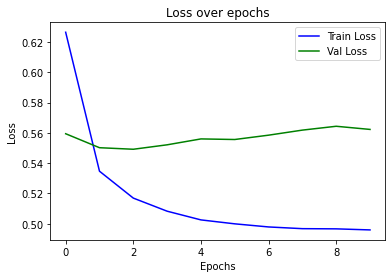

In [18]:
fitLSTM()

<h1> BERT Embeddings </h1>

In [19]:
import os
from transformers import BertTokenizer, BertModel, pipeline

# create a function to tokenize the text to BERT embeddings    
def BERTtokenizeTweets(df):
    pretrained_weights = "bert-base-cased"
    tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
    model = BertModel.from_pretrained(pretrained_weights)
    nlp = pipeline("feature-extraction", tokenizer=tokenizer, model=model)
    vectorized_docs = []
    count = 0
    
    for index, row in df.iterrows():
        vec = np.array(nlp(row["text"][:512]))
        meanVec = vec.reshape((vec.shape[1], vec.shape[2])).mean(axis=0)
        vectorized_docs.append(meanVec)
        count = count + 1
        if count % 1000 == 0:
            print("->"+str(count)) 

    return np.array(vectorized_docs)

# convert the data to BERT tokenized text
train_features = BERTtokenizeTweets(train_df)
val_features = BERTtokenizeTweets(val_df)
test_features = BERTtokenizeTweets(test_df)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


->1000
->2000
->3000
->4000
->5000
->6000
->7000
->8000
->9000
->10000
->11000
->12000
->13000
->14000
->15000
->16000
->17000
->18000
->19000
->20000


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


->1000
->2000


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


->1000
->2000


In [143]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# fitting a support vector machine and performing gridsearch
parameters = [{'kernel': ['linear','rbf'], 'gamma': [1e-3, 1e-4],
                      'C': [1, 10, 100]}]
svc = SVC()
clf = GridSearchCV(svc, parameters)
tuning_results = clf.fit(train_features,train_labels)

#printing the best parameters for SVM
print(clf.best_params_)

#generate predictions for test dataset
grid_predictions = clf.predict(test_features) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions)) 

{'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1278
           1       0.83      0.86      0.85      1280

    accuracy                           0.84      2558
   macro avg       0.84      0.84      0.84      2558
weighted avg       0.84      0.84      0.84      2558



In [144]:
from sklearn.linear_model import LogisticRegression

# fitting a logistic regression and performing gridsearch
lr = LogisticRegression(solver='liblinear')
parameters = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}

lr_clf = GridSearchCV(lr, parameters)
lr_clf.fit(train_features,train_labels)

#printing the best parameters for LR
print(lr_clf.best_params_) 

#generate predictions for test dataset
grid_predictions = lr_clf.predict(test_features) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions))

{'C': 1}
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1278
           1       0.83      0.85      0.84      1280

    accuracy                           0.84      2558
   macro avg       0.84      0.84      0.84      2558
weighted avg       0.84      0.84      0.84      2558



In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# fitting a Random Forest Classifier and performing gridsearch
random_state = 523
n_estimators = [100, 300]
max_depth = [15, 30]
min_samples_split = [10, 15]
min_samples_leaf = [ 5, 10] 

parameters = {'n_estimators' : n_estimators, 'max_depth' : max_depth,  
              'min_samples_split' : min_samples_split, 
            'min_samples_leaf' : min_samples_leaf}


rf = RandomForestClassifier(random_state=0)
print(rf.get_params().keys())
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(train_features,train_labels)

#printing the best parameters for RF
print(rf_clf.best_params_)

#generate predictions for test dataset
grid_predictions = rf_clf.predict(test_features) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions)) 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1278
           1       0.80      0.87      0.83      1280

    accuracy                           0.83      2558
   macro avg       0.83      0.83      0.82      2558
weighted avg       0.83      0.83      0.82      2558



In [21]:
from torch.utils.data import Dataset, DataLoader
import scipy

#loading the dataset and dataloader

BERTtrain_dataset = TweetDataset(train_features,y_train)
BERTtrain_loader = DataLoader(dataset = BERTtrain_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

BERTval_dataset = TweetDataset(val_features,y_val)
BERTvalid_loader = DataLoader(dataset = BERTval_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

BERTtest_dataset = TweetDataset(test_features,y_test)
BERTtest_loader = DataLoader(dataset = BERTtest_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)

In [22]:
import time

def fitBERTLSTM():
    # initialize the hyperparameters
    train_losses=[]
    train_accu=[]
    eval_losses = []
    num_epochs = 10
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(input_size, hidden_size, num_classes).to(device)
    
    # initialize the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    min_valid_loss = np.inf
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        correct=0
        total=0
        running_loss=0
        for (words, labels) in BERTtrain_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            
            # Forward prop
            outputs = model(words)
            loss = criterion(outputs, labels)

            # Backward prop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            running_accuracy = 0 
            total = 0
            
        # calculate accuracy and store the train loss
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss=running_loss/len(BERTtrain_loader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(train_loss)

        # Validate the model
        running_loss = 0.0
        model.eval()     
        for data, labels in BERTvalid_loader:
            data = data.cuda()
            labels = labels.cuda()

            # Forward Pass
            target = model(data.float())
            # Find the Loss
            loss = criterion(target,labels)
            # Calculate Loss
            running_loss += loss.item()
            
        #store the valid loss
        valid_loss = running_loss/len(BERTvalid_loader)
        eval_losses.append(valid_loss)
        
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_model_bert.pth')
            
        if (epoch+1) % 1 == 0:
            print('For Epoch %d ,Loss on Train set: %f' % (epoch+1, train_loss)) 
            print('For Epoch %d, Loss on Validation set: %f' % (epoch+1, valid_loss))
        
    
    
    # print the training time
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    # Test the model
    path = "saved_model_bert.pth" 
    model.load_state_dict(torch.load(path)) 
    
    running_accuracy = 0 
    total = 0 
    pred = []
    with torch.no_grad(): 
        for inputs, outputs in BERTtest_loader: 
            inputs = inputs.cuda()
            outputs = outputs.cuda()
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs.float()) 
            _, predicted = torch.max(predicted_outputs, 1)
            pred.append(predicted.cpu())
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item()
            
        #print the classification report for precision, recall and F1 score
        pred = torch.cat(pred)
        print(classification_report(pred,y_test))
 
        
    print('Accuracy of the model based on the test set of inputs is: %d %%' % (100 * running_accuracy / total))
    
    # print the accuracy by label
    labels_length = 2
    labels_correct =[0. for i in range(labels_length)] 
    labels_total = [0. for i in range(labels_length)]
  
    with torch.no_grad(): 
         for inputs, outputs in BERTtest_loader: 
            inputs = inputs.cuda()
            outputs = outputs.cuda()
            predicted_outputs = model(inputs.float()) 
            _, predicted = torch.max(predicted_outputs, 1) 
             
            for i in range(len(predicted)):
                if predicted[i] == outputs[i]:
                    labels_correct[outputs[i]] += 1
                labels_total[outputs[i]] += 1

    
    for i in range(2):
        print('Accuracy to predict %5s : %2d %%' % (i, 100 * labels_correct[i] / labels_total[i]))
        
    # plot the losses per epoch    
    plot_epochs = [i for i in range(num_epochs)]
    plt.plot(plot_epochs,train_losses,label="Train Loss",color="blue")
    plt.plot(plot_epochs,eval_losses,label="Val Loss",color="green")
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('bert_loss.pdf')

In [23]:
fitBERTLSTM()

RuntimeError: input.size(-1) must be equal to input_size. Expected 20872, got 768